In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.3 MB/s eta 0:00:00


In [2]:
!pip install torchinfo

In [3]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from google.colab import files
uploaded = files.upload()

Saving London_hotel_reviews_balanced_only_subsampled.csv to London_hotel_reviews_balanced_only_subsampled.csv


In [7]:
torch.cuda.empty_cache()

In [8]:
df = pd.read_csv('/content/London_hotel_reviews_balanced_only_subsampled.csv')
df.head()

,Property Name,sentence,label
0,Mondrian London at Sea Containers,'''nice visit but did not feel special. upgrad...,1
1,"The Wellesley Knightsbridge, a Luxury Collecti...","'''we stayed for a few days in october, and it...",1
2,The Savoy,"'''lovely furnishings, amenities and service. ...",1
3,Mondrian London at Sea Containers,'''we stayed here for 3 nights and was expecti...,1
4,The Rembrandt,'''visited for a 2 night stay rooms were ok bu...,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3816 entries, 0 to 3815
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Property Name  3816 non-null   object
 1   sentence       3816 non-null   object
 2   label          3816 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 89.6+ KB


<Axes: >

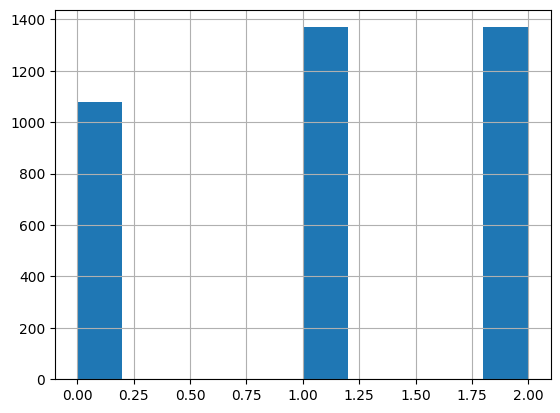

In [10]:
df['label'].hist() #To check the balance in data

In [11]:
df['label'].value_counts()

1    1369
2    1369
0    1078
Name: label, dtype: int64

In [13]:
from google.colab import files
uploaded = files.upload()

Saving London_hotel_reviews_test_small.csv to London_hotel_reviews_test_small.csv


In [14]:
test_df = pd.read_csv('/content/London_hotel_reviews_test_small.csv')
test_df

,Property Name,sentence,label,prediction
0,Apex London Wall Hotel,'''although there is nothing wrong with theis ...,1,1
1,The Savoy,'''so this was my first time staying at the sa...,2,1
2,The Dorchester,'''everyone should have the opportunity to sta...,2,2
3,Hartley Hotel,'''please do not stay in this hotel. in name o...,0,0
4,Mondrian London at Sea Containers,'''first time stay here but sadly not impresse...,1,1
...,...,...,...,...
186,Apex London Wall Hotel,'''a 'budget' room here is 225... | signal and...,0,0
187,The Rembrandt,'''went to the hotel sunday 23 aug as part of ...,0,0
188,Corinthia Hotel London,'''tried the hotel for breakfast today .... fu...,1,1
189,Rhodes Hotel,'''my fiance and i booked to stay for four nig...,0,0


In [18]:
sentences_to_drop = test_df['sentence'].tolist()
condition = df['sentence'].isin(sentences_to_drop)
train_df = df[~condition]
train_df

,Property Name,sentence,label
0,Mondrian London at Sea Containers,'''nice visit but did not feel special. upgrad...,1
1,"The Wellesley Knightsbridge, a Luxury Collecti...","'''we stayed for a few days in october, and it...",1
2,The Savoy,"'''lovely furnishings, amenities and service. ...",1
3,Mondrian London at Sea Containers,'''we stayed here for 3 nights and was expecti...,1
4,The Rembrandt,'''visited for a 2 night stay rooms were ok bu...,1
...,...,...,...
3811,The Rembrandt,'''stayed here just for 1 night in april on a ...,2
3812,Ridgemount Hotel,'''we stayed at the ridgemount hotel in london...,2
3813,The Rembrandt,'''the location is south kensington is perfect...,2
3814,The Savoy,'''i have stayed at the savoy a couple of time...,2


In [19]:
train_df.to_csv('/content/London_hotel_reviews_train_small.csv', index = False)

In [20]:
raw_dataset = load_dataset('csv', data_files = '/content/London_hotel_reviews_train_small.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [21]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['Property Name', 'sentence', 'label'],
        num_rows: 3625
    })
})

In [22]:
# CHANGE 'checkpoint' TO CHANGE THE MODEL
checkpoint  = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation = True, padding = True)

# truncation = True means that the function will truncate sequences that are longer than the maximum length specfied by the model.

In [24]:
tokenized_dataset = raw_dataset.map(tokenize_fn, batched = True)

Map:   0%|          | 0/3625 [00:00<?, ? examples/s]

In [25]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Property Name', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3625
    })
})

In [26]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis = -1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [28]:
num_folds = 3

fold_metrics = []

cv = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)

for fold, (train_idx, eval_idx) in enumerate(cv.split(tokenized_dataset['train']['sentence'], tokenized_dataset['train']['label'])):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)
    model.to(device)

    train_data = tokenized_dataset['train'].select(train_idx)
    eval_data = tokenized_dataset['train'].select(eval_idx)

    training_args = TrainingArguments(
        output_dir = f'/content/training_dir_fold_{fold}',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        num_train_epochs = 3,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 16,
        logging_steps = 100,
    )

    trainer = Trainer(
        model,
        training_args,
        train_dataset = train_data,
        eval_dataset = eval_data,
        tokenizer = tokenizer,
        compute_metrics = compute_metrics,
    )

    trainer.train()

    fold_metrics.append(trainer.evaluate())

    torch.cuda.empty_cache()

avg_accuracy = sum(metrics['eval_accuracy'] for metrics in fold_metrics) / num_folds

print(f'Average Cross-Validation Accuracy: {avg_accuracy}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.789300,0.632400,0.739454,0.739454
2,0.419800,0.513371,0.790736,0.790736
3,0.236200,0.646898,0.786600,0.786600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.745400,0.602356,0.734272,0.734272
2,0.413100,0.547737,0.767384,0.767384
3,0.220100,0.733966,0.763245,0.763245


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.731900,0.554591,0.775662,0.775662
2,0.414000,0.568932,0.780629,0.780629
3,0.249400,0.593045,0.798013,0.798013


Average Cross-Validation Accuracy: 0.782619591474537


In [29]:
fold_metrics

[{'eval_loss': 0.6468976140022278,
  'eval_accuracy': 0.7866004962779156,
  'eval_f1_score': 0.7866004962779156,
  'eval_runtime': 42.295,
  'eval_samples_per_second': 28.585,
  'eval_steps_per_second': 1.797,
  'epoch': 3.0},
 {'eval_loss': 0.7339658141136169,
  'eval_accuracy': 0.7632450331125827,
  'eval_f1_score': 0.7632450331125827,
  'eval_runtime': 42.6689,
  'eval_samples_per_second': 28.311,
  'eval_steps_per_second': 1.781,
  'epoch': 3.0},
 {'eval_loss': 0.5930454730987549,
  'eval_accuracy': 0.7980132450331126,
  'eval_f1_score': 0.7980132450331126,
  'eval_runtime': 42.624,
  'eval_samples_per_second': 28.341,
  'eval_steps_per_second': 1.783,
  'epoch': 3.0}]

In [31]:
model_dir = '/content/training_dir_fold_2/checkpoint-456'  # Checkpoint with highest validation accuracy after 3 epochs
saved_model = AutoModelForSequenceClassification.from_pretrained(model_dir)

tokenizer = AutoTokenizer.from_pretrained(model_dir)
test_encodings = tokenizer(test_df['sentence'].to_list(), truncation = True, padding = True, return_tensors = 'pt')

# Make predictions
with torch.no_grad():
    logits = saved_model(**test_encodings)
    probabilities = torch.softmax(logits.logits, dim = 1)

# Extract the predicted labels
predicted_labels = torch.argmax(probabilities, dim = 1)

In [32]:
predicted_labels

tensor([1, 1, 2, 0, 1, 0, 2, 0, 1, 2, 0, 0, 1, 0, 2, 0, 1, 2, 0, 2, 1, 1, 1, 1,
        2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 2, 2, 0, 1, 1, 2, 0, 2, 1, 2, 2, 2, 2, 1,
        2, 1, 2, 1, 0, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 2, 1, 0, 1,
        2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 0, 2, 0, 1,
        0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 0, 0, 2, 2,
        2, 0, 2, 2, 0, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 0, 0, 2, 1, 2,
        0, 2, 0, 0, 0, 2, 0, 0, 1, 2, 2, 2, 0, 0, 2, 1, 2, 1, 0, 2, 0, 2, 2, 2,
        0, 1, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1, 2, 2, 2, 0, 0, 1, 0, 0])

In [33]:
predictions = predicted_labels.numpy()
predictions = predictions.tolist()
ground_truth_labels = test_df['label'].to_list()

# Compare labels and calculate accuracy
correct_predictions = sum(1 for p, g in zip(predictions, ground_truth_labels) if p == g)
accuracy = correct_predictions / len(ground_truth_labels)
print("accuracy = ", accuracy)

f1 = f1_score(ground_truth_labels, predicted_labels, average = 'micro')
print('f1_score = ', f1)

accuracy =  0.8010471204188482
f1_score =  0.8010471204188482


In [34]:
import pickle as pkl
vars_to_store = [ground_truth_labels, predictions]

with open('/content/bert-base-uncased_small.pkl', 'wb') as f:
    pkl.dump(vars_to_store , f) # serialize the list

### to unpickle and get the variables you need:
with open('/content/bert-base-uncased_small.pkl', 'rb') as f:
    vars_to_load = pkl.load(f) # deserialize

#vars_to_load is that same list of variables you pickled, just get each one by slicing the list

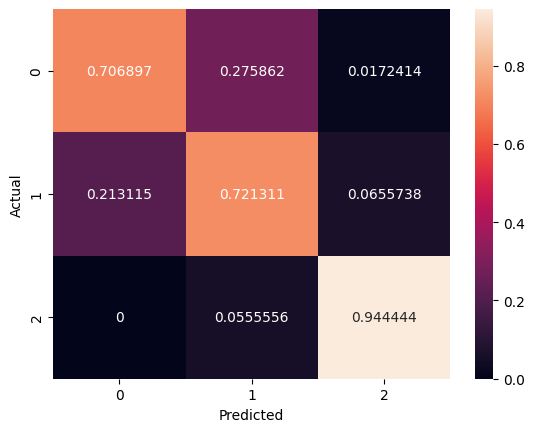

In [35]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['0','1','2']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(vars_to_load[0], vars_to_load[1], normalize = 'true')
plot_cm(cm)